**Pedro Rivero**  
Quantum Developer *@ IBM Quantum*  
pedro.rivero@ibm.com 

# Zero noise extrapolation (ZNE)
Learn how to mitigate errors in your expectation value calculations using a technique known as _Zero noise extrapolation_ (ZNE). 

This software is built on top the the _Estimator_ primitive therefore, to follow along, basic familiriaty with said tool is requiered and will be assumed. See here for [introductory material](0-estimator.ipynb).


## Overview of ZNE
![Zero noise extrapolation (ZNE)](../media/zne.png)

### Noise amplification
The original implementation of ZNE carried out noise amplification at the hardware level (i.e. _analog_ noise amplification), by moduling the microwave pulses implementing the ciruit's unitary gates. This process is significantly involved and requires calibration of the device before each noisy experiment, which is why a more relaxed alternative was devised: gate folding (i.e. _digital_ noise amplification).
![Noise amplification](../media/noise_amplification-folding.png)

### Extrapolation
This process was first carried out with a technique known as _Richardson extrapolation_. Nonetheless, we often use general regression methods to account for several different noise profiles:
![Extrapolation](../media/noise_profile.png)


## Demo
This module works by injecting ZNE capabilities in any given implementation of the _Estimator_ primitive. Once this functionality is in place, it can be controlled through a `ZNEStrategy` object that encapsulates all necessary information for customizing the error mitigation process.

### Building a ZNE Estimator
Since we are going to be showcasing error mitigation, we need our calculations to be noisy. Therefore, we are going to be using `qiskit.primitives.BackendEstimator` alongside a fake noisy backend:

In [1]:
from qiskit.primitives import BackendEstimator
from qiskit.providers.fake_provider import FakeNairobi  # We need noise!
from zne import zne

ZNEEstimator = zne(BackendEstimator)  # Any implementation of BaseEstimator is valid
backend = FakeNairobi()
estimator = ZNEEstimator(backend=backend)

Notice how the `zne()` function, takes in any class implementing the `BaseEstimator` interface, and outputs a new, equivalent, class updated with ZNE capabilities. This new class is used in exactly the same way as its predecessor (i.e. can be configured in the same way), except that it will now accept on extra option describing the ZNE workflow that the user wants to accomplish: `zne_strategy`.

Now that we have instantiated our estimator, lets put it to work:

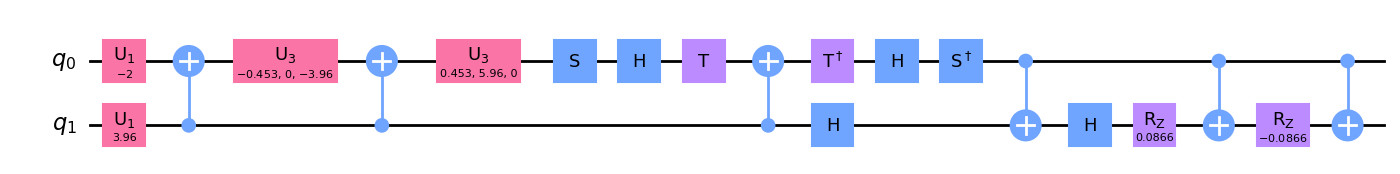

  > Observable: ['ZZ']
  > Expectation value: 0.921875
  > Metadata: {'variance': 0.150146484375, 'shots': 1024}


In [2]:
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

circuit = random_circuit(2, 4, seed=1).decompose(reps=1)
observable = SparsePauliOp("ZZ")

job = estimator.run(circuit, observable)
result = job.result()

display(circuit.draw("mpl"))
print(f"  > Observable: {observable.paulis}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

And let's compare these results with an ideal simulation:

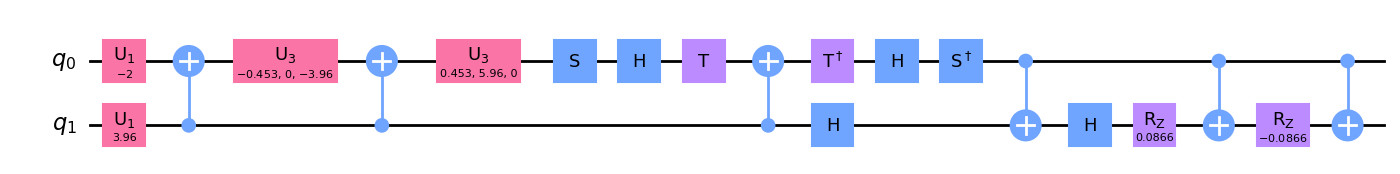

  > Observable: ['ZZ']
  > Expectation value: 0.9999999999999984
  > Metadata: {}


In [3]:
from qiskit.primitives import Estimator

circuit = random_circuit(2, 4, seed=1).decompose(reps=1)
observable = SparsePauliOp("ZZ")

job = Estimator().run(circuit, observable)  # !!!
result = job.result()

display(circuit.draw("mpl"))
print(f"  > Observable: {observable.paulis}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

Wait a second... the result with ZNE doesn't seem to be that good after all!

That is because on the previous run, ZNE wasn't activated. Since no `zne_strtegy` option was provided, it defaulted to the standard behavior without error mitigation. This is a design feature, not a bug: in the sake of versatility.

<div class="alert alert-info">
    <i class="fas fa-info-circle"></i>
    <b>NOTICE</b><br/> 
    You can always change the default by passing the extra <code>zne_strategy</code> kwarg on instantiation, or editing the attribute with the same name:  
    <pre><code>
    estimator = ZNEEstimator(backend=backend, zne_strategy=zne_strategy)
    estimator.zne_strategy = zne_strategy
    </code></pre>
</div>

### Configuring ZNE

#### Noise factors
The easiest thing you can do to configure ZNE is providing a set of `noise_factors` to use:

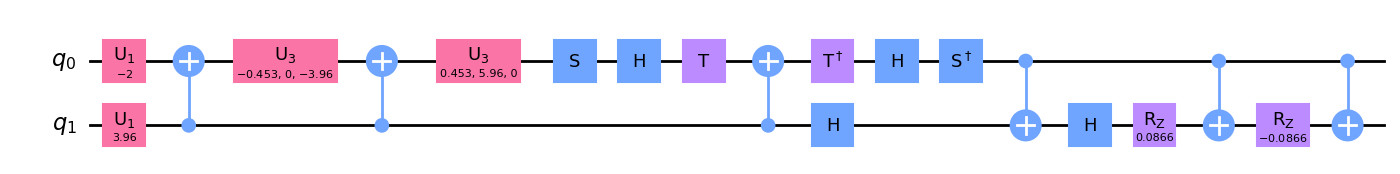

  > Observable: ['ZZ']
  > Expectation value: 0.9265950520833337
  > Metadata: {'zne': {'noise_amplification': {'noise_amplifier': <CxAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>, 'noise_factors': (1, 3, 5), 'values': (0.89453125, 0.822265625, 0.759765625), 'variance': (0.1998138427734375, 0.3238792419433594, 0.4227561950683594), 'shots': (1024, 1024, 1024)}, 'extrapolation': {'extrapolator': LinearExtrapolator}}}


In [4]:
from zne import ZNEStrategy

circuit = random_circuit(2, 4, seed=1).decompose(reps=1)
observable = SparsePauliOp("ZZ")

zne_strategy = ZNEStrategy(noise_factors=[1, 3, 5])
job = estimator.run(circuit, observable, zne_strategy=zne_strategy)  # !!!
result = job.result()

display(circuit.draw("mpl"))
print(f"  > Observable: {observable.paulis}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

This time around we indeed got an improvement in the computed expectation value, which is now closer to the `exact = 1.0`.

But the metadata looks very complex now! As a matter of fact, a lot of relevant information regarding the ZNE process has now been stored in an entry labeled `zne`. This entry is at the same time divided in two: `noise_amplification` and `extrapolation`, each of which holding intel on the corresponding task.

Let's serialize it to jason and pretty print it to see what is going on more clearly:

In [5]:
from zne.utils.serialization import EstimatorResultEncoder

print(EstimatorResultEncoder.dumps(result, indent=2))

{
  "values": [
    0.9265950520833337
  ],
  "metadata": [
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "<CxAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
          "noise_factors": [
            1,
            3,
            5
          ],
          "values": [
            0.89453125,
            0.822265625,
            0.759765625
          ],
          "variance": [
            0.1998138427734375,
            0.3238792419433594,
            0.4227561950683594
          ],
          "shots": [
            1024,
            1024,
            1024
          ]
        },
        "extrapolation": {
          "extrapolator": "LinearExtrapolator"
        }
      }
    }
  ]
}


It is now clear that within `noise_amplification`, we can find all the information concerning the noisy experiements (e.g. noise factors, noisy values, estimated variances, shots). But there is one other entry: `noise_amplifier`.

#### Noise amplifier
As mentioned above, there are several different ways of amplifying the noise in your circuit, some of them being more involved than others. In this module we include two digital techniques: 
- `LocalFoldingAmplifier` 
- `GlobalFoldingAmplifier`

In [6]:
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier

global_amplifier = GlobalFoldingAmplifier()
local_amplifier = LocalFoldingAmplifier(gates_to_fold=2)  # Fold two-qubit gates

zne_strategy = ZNEStrategy(
    noise_factors=range(1, 9), 
    noise_amplifier=local_amplifier,
)

If no `noise_amplifier` is provide, a default will be applied: `LocalFoldingAmplifier` folding all gates. See [this tutorial](2-noise_amplification.ipynb) for more information on how to configure and use these noise amplification strategies.

#### Extrapolator
In the metadata, we also see an entry similar to `noise_amplifier`, but under `extrapolation`: `extrapolator`. In this module we provide a basic `PolynomialExtrapolator` whose degree can be configured at will and default to `degree = 1`.

In [7]:
from zne.extrapolation import PolynomialExtrapolator

extrapolator = PolynomialExtrapolator(degree=2)

zne_strategy = ZNEStrategy(
    noise_factors=[1.0, 1.5, 2.0], 
    extrapolator=extrapolator
)

#### Custom ZNE strategies
Furthermore, the current implementation of `ZNEStrategy` allows us to easily build custom noise amplification, and extrapolation techniques:

In [8]:
from zne.extrapolation import Extrapolator, ReckoningResult
from zne.noise_amplification import CircuitNoiseAmplifier


############################  NOISE AMPLIFIER  ############################
class CustomAmplifier(CircuitNoiseAmplifier):
    def amplify_circuit_noise(self, circuit, noise_factor):
        return circuit.copy()  # Dummy, nonperforming


############################  EXTRAPOLATOR  ############################
class CustomExtrapolator(Extrapolator):
    @property
    def min_points(self):
        return 2
    
    def _extrapolate_zero(self, x_data, y_data, sigma_x, sigma_y):
        value = 1.0
        std_error = 1.0
        metadata = {"meta": "data"}
        return ReckoningResult(value, std_error, metadata)  # Dummy, nonperforming

And we see that it now runs by passing it through `zne_strategy`.

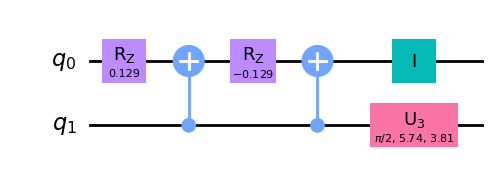

  > Observable: ['ZZ']
  > Expectation value: 1.0
  > Metadata: {'zne': {'noise_amplification': {'noise_amplifier': CustomAmplifier, 'noise_factors': (1, 3), 'values': (0.03125, 0.025390625), 'variance': (0.9990234375, 0.9993553161621094), 'shots': (1024, 1024)}, 'extrapolation': {'extrapolator': CustomExtrapolator, 'variance': 0.0, 'metadata': None}}}


In [9]:
circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
observable = SparsePauliOp("ZZ")

zne_strategy = ZNEStrategy(
    noise_factors=(1, 3),
    noise_amplifier=CustomAmplifier(),
    extrapolator=CustomExtrapolator(),
)

job = estimator.run(circuit, observable, zne_strategy=zne_strategy)
result = job.result()

display(circuit.draw("mpl"))
print(f"  > Observable: {observable.paulis}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

Notice how the mitigated value is indeed `value = 1.0` and the variance (i.e. in `extrapolation`) is `variance = 0.0`, just as we defined in our dummy implementation.

### Complete run
To wrap up, let us go through a complete run and plot the results.

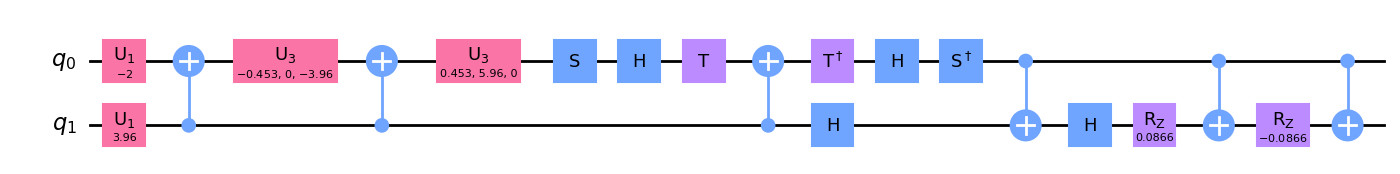

  > Observable: ['ZZ']
  > Expectation value: 0.9619140625000004
  > Metadata: {'zne': {'noise_amplification': {'noise_amplifier': <LocalFoldingAmplifier:{'gates_to_fold': 2, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>, 'noise_factors': (1, 2, 3, 4, 5, 6, 7, 8), 'values': (0.892578125, 0.87890625, 0.82421875, 0.80078125, 0.75, 0.701171875, 0.6953125, 0.70703125), 'variance': (0.20330429077148438, 0.2275238037109375, 0.3206634521484375, 0.3587493896484375, 0.4375, 0.5083580017089844, 0.51654052734375, 0.5001068115234375), 'shots': (1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024)}, 'extrapolation': {'extrapolator': <PolynomialExtrapolator:{'degree': 2}>}}}


In [10]:
from qiskit.circuit.random import random_circuit
from qiskit.primitives import BackendEstimator
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.quantum_info import SparsePauliOp
from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

## Build ZNEEstimator
ZNEEstimator = zne(BackendEstimator)
backend = FakeNairobi()
estimator = ZNEEstimator(backend=backend)

## Build our input circuit and observable
circuit = random_circuit(2, 4, seed=1).decompose(reps=1)
observable = SparsePauliOp("ZZ")

## Build a ZNE strategy
zne_strategy = ZNEStrategy(
    noise_factors=range(1, 9),
    noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
    extrapolator=PolynomialExtrapolator(degree=2),
)

## Run experiment
job = estimator.run(circuit, observable, zne_strategy=zne_strategy)  # !!!
result = job.result()

## Display results
display(circuit.draw("mpl"))
print(f"  > Observable: {observable.paulis}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

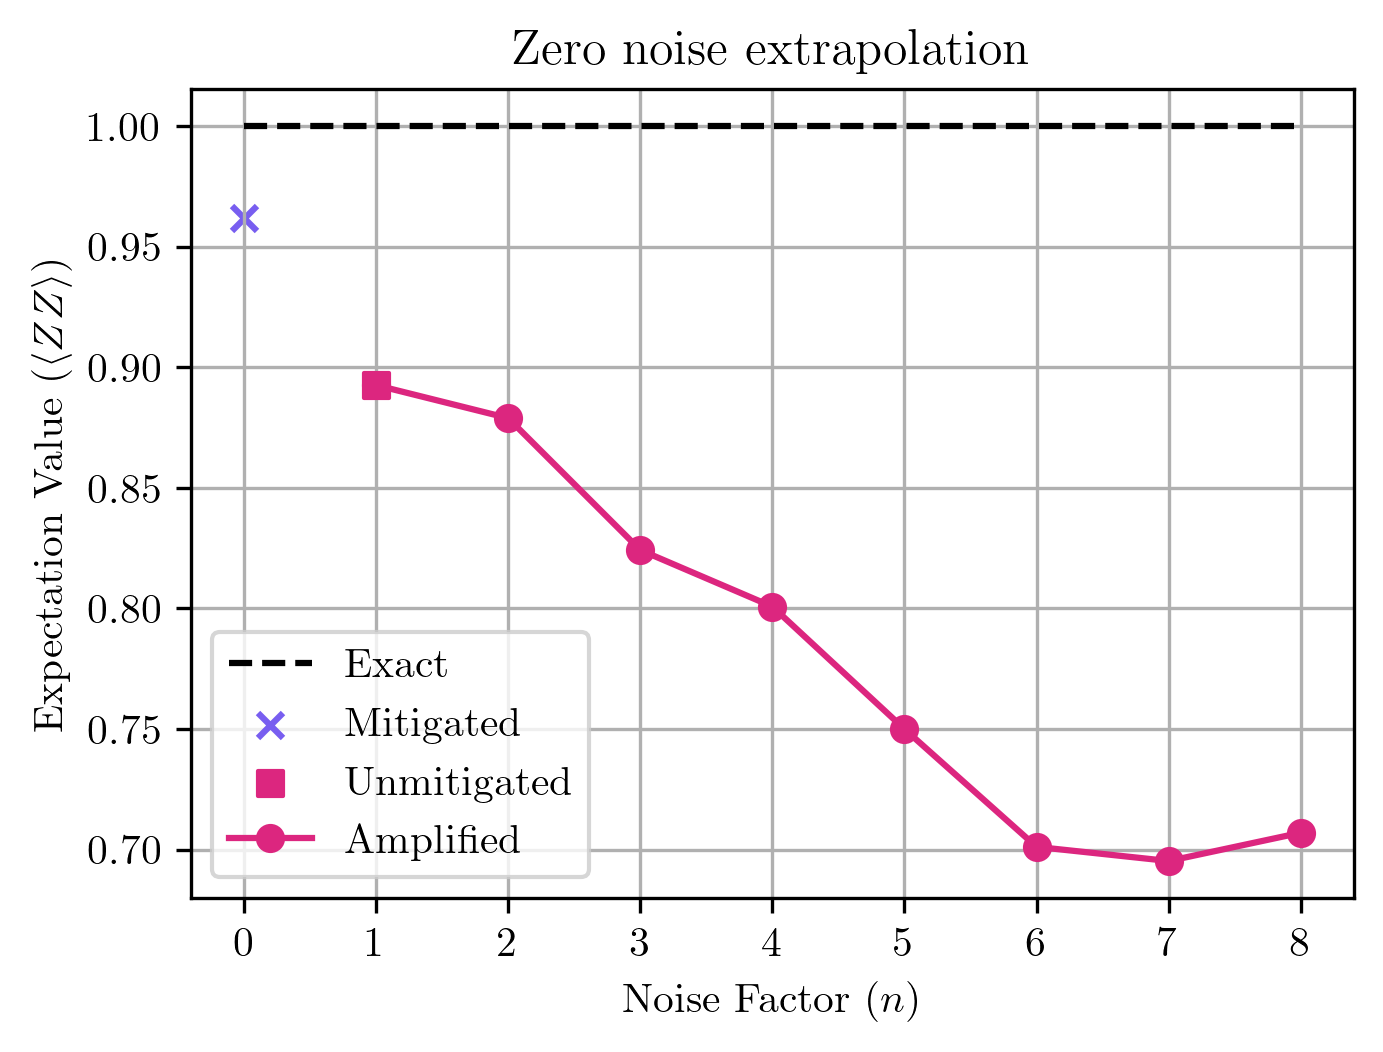

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.dpi"] = 300
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern Roman"})

############################  DATA  ############################
exact = 1  # From simulation above
mitigated = result.values[0]
noise_factors = result.metadata[0]["zne"]["noise_amplification"]["noise_factors"]
noisy_values = result.metadata[0]["zne"]["noise_amplification"]["values"]

############################  PLOT  ############################
plt.rcParams["figure.figsize"] = (5,3.5)
plt.grid(which='major',axis='both')

plt.plot([0, noise_factors[-1]], [exact, exact], "--", label=f"Exact", color="#000000")
plt.scatter(0, mitigated, label=f"Mitigated", marker="x", color="#785ef0")
if noise_factors[0] == 1:
    plt.scatter(
        noise_factors[0], noisy_values[0], 
        label=f"Unmitigated", marker="s", color="#dc267f",
    )
plt.plot(
    noise_factors, noisy_values, 
    label=f"Amplified", marker="o", color="#dc267f",
)

plt.title("Zero noise extrapolation")
plt.xlabel("Noise Factor ($n$)")
plt.ylabel(f"Expectation Value ($\langle ZZ \\rangle$)")
plt.legend()

plt.show()

In [12]:
import qiskit.tools.jupyter  # pylint: disable=unused-import,wrong-import-order

%qiskit_version_table
%qiskit_copyright